In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Load and prepare data
df = pd.read_csv('u18_composite.csv')
df.describe()

,Height,U18 Season,PTS/G,PPP,D1 PPG,Composite Score
count,126.000000,126.000000,126.000000,126.000000,118.000000,126.000000
mean,560.769841,2020.388889,7.482540,0.719603,6.706780,0.445794
std,46.385026,2.093694,4.076137,0.180882,5.390047,0.214157
min,506.000000,2017.000000,1.000000,0.280000,0.000000,0.107000
25%,510.000000,2018.000000,4.000000,0.594750,2.625000,0.279250
50%,600.000000,2021.000000,7.000000,0.715500,6.000000,0.415500
75%,602.000000,2022.000000,10.000000,0.858500,9.850000,0.596000
max,606.000000,2024.000000,18.000000,1.314000,28.000000,0.970000


In [9]:

# Feature engineering
# Height conversion
df['Height'] = pd.to_numeric(df['Height'], errors = 'coerce').astype(int)
#IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer
df['Height_in'] = df['Height'].apply(lambda x: int(str(x)[0])*12 + int(str(x)[1:]))
print(df[['Player', 'Height', 'Height_in']].head())


                   Player  Height  Height_in
0  Charlisse Leger-Walker     510         70
1               Tess Heal     510         70
2           Nyara Sabally     605         77
3            Emme Shearer     600         72
4              Tyana Todd     600         72


In [10]:

df['D1_PPG_available'] = np.where(df['D1 PPG'] == 'TBD', 0, 1)

# Select features and target
features = ['PTS/G', 'PPP', 'Height_in', 'U18 Season']
target = 'Composite Score'

# Handle missing values
df_clean = df.dropna(subset=features + [target])
X = df_clean[features]
y = df_clean[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [11]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# KNN Model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Evaluation
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"KNN Model MSE: {mse:.4f}")


KNN Model MSE: 0.0375


In [12]:

# Feature Importance Analysis
# 1. Permutation Importance
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

print("\nPermutation Importance:")
print(importance_df)



Permutation Importance:
      Feature  Importance       Std
3  U18 Season    0.238795  0.123804
0       PTS/G    0.168537  0.132716
1         PPP    0.045776  0.113271
2   Height_in   -0.007286  0.103566


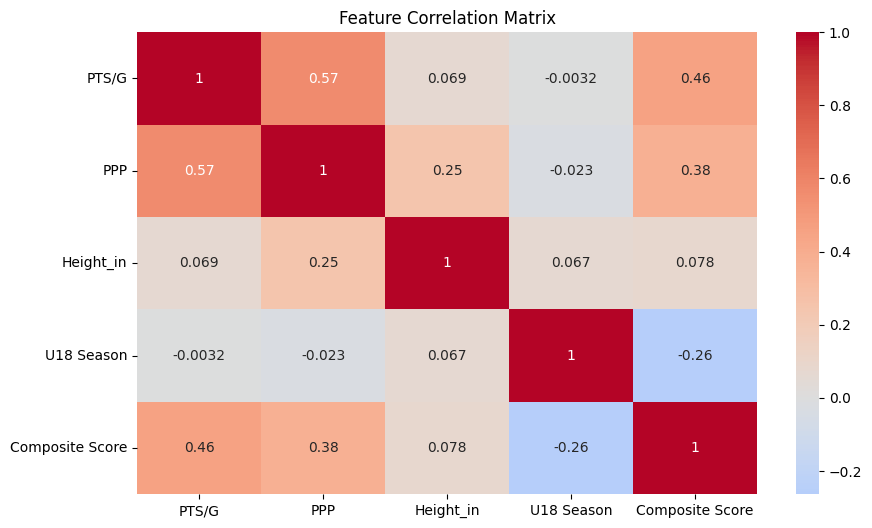

In [13]:

# 2. Correlation Analysis
corr_matrix = df_clean[features + [target]].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()


In [15]:

# 4. KNN Performance by Feature Subset
feature_combinations = [
    ['PTS/G', 'PPP'],
    ['PTS/G', 'Height_in'],
    ['PPP', 'Height_in'],
    ['PTS/G', 'PPP', 'Height_in']
]

for combo in feature_combinations:
    X_combo = df_clean[combo]
    X_scaled = scaler.fit_transform(X_combo)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    print(f"\nR² Score using {combo}: {score:.3f}")



R² Score using ['PTS/G', 'PPP']: -0.155

R² Score using ['PTS/G', 'Height_in']: 0.187

R² Score using ['PPP', 'Height_in']: -0.507

R² Score using ['PTS/G', 'PPP', 'Height_in']: -0.022


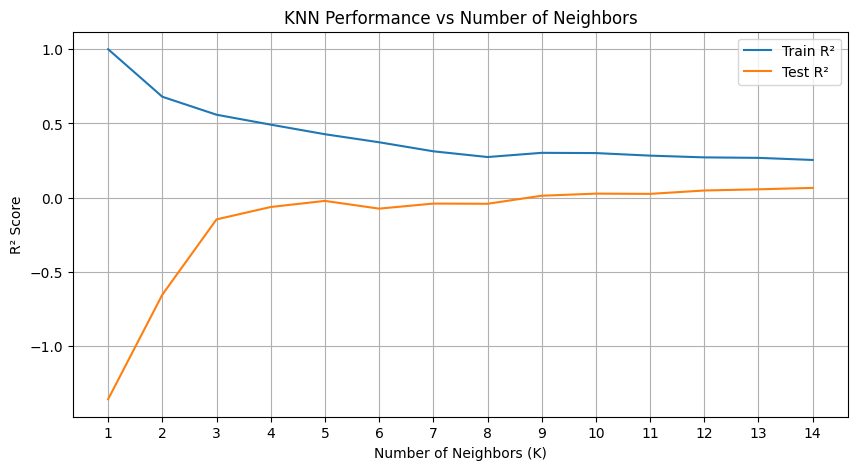

In [16]:

# 5. Optimal K Value Selection
k_values = range(1, 15)
test_scores = []
train_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(k_values, train_scores, label='Train R²')
plt.plot(k_values, test_scores, label='Test R²')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('R² Score')
plt.title('KNN Performance vs Number of Neighbors')
plt.legend()
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Use the scaled features for clustering
n_clusters = 3  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df_clean['Cluster'] = clusters

# Print tables of players in each cluster
for cluster_id in range(n_clusters):
    print(f"\nCluster {cluster_id}:")
    display(df_clean[df_clean['Cluster'] == cluster_id][['Player', 'PTS/G', 'PPP', 'Height_in', 'Composite Score']])


Cluster 0:


,Player,PTS/G,PPP,Height_in,Composite Score
1,Tess Heal,7.0,0.897,70,0.932
5,Jasmine Bascoe,7.0,0.721,67,0.838
7,Keishana Washington,7.0,0.870,67,0.835
14,Eleonora Villa,7.0,0.788,68,0.762
22,Mary-Anna Asare,9.0,0.709,68,0.668
23,Isabel Palmer,9.0,0.691,69,0.657
31,Jaz Shelley,9.0,0.602,69,0.598
32,Taya Hanson,10.0,0.667,71,0.590
35,Sofia Kelemeni,7.0,0.515,72,0.555
36,Lemyah Hylton,8.0,0.533,71,0.540



Cluster 1:


,Player,PTS/G,PPP,Height_in,Composite Score
3,Emme Shearer,4.0,0.786,72,0.872
6,Skylar Forbes,6.0,0.737,75,0.838
8,Freja Werth,5.1,0.700,73,0.822
10,Sam Simons,6.0,0.548,74,0.788
13,Stina Almqvist,7.3,0.590,73,0.770
16,Ioanna Chatzileonti,11.0,0.624,74,0.713
17,Emma Clarke,7.0,0.717,73,0.713
18,Carly Ahlstrom,7.0,0.635,72,0.707
21,Praise Egharevba,4.0,0.750,75,0.670
26,Caterina Piatti,7.0,0.662,76,0.633



Cluster 2:


,Player,PTS/G,PPP,Height_in,Composite Score
0,Charlisse Leger-Walker,14.0,0.742,70,0.970
2,Nyara Sabally,12.0,0.935,77,0.890
4,Tyana Todd,15.0,1.100,72,0.847
9,Ioanna Krimili,17.0,0.928,70,0.807
11,Matilda Ekh,14.8,0.940,74,0.780
12,Sophie Burrows,9.0,1.314,74,0.780
15,Agnes Emma-Nnopu,9.0,0.883,71,0.757
19,Emily Bessoir,12.0,0.838,76,0.700
20,Christina Morra,15.0,0.946,74,0.683
24,Tova Sabel,10.0,0.840,71,0.635


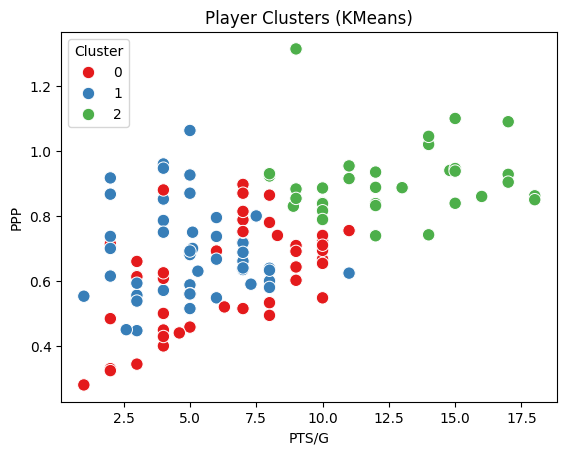

In [18]:
sns.scatterplot(
    data=df_clean,
    x='PTS/G',
    y='PPP',
    hue='Cluster',
    palette='Set1',
    s=80
)
plt.title('Player Clusters (KMeans)')
plt.xlabel('PTS/G')
plt.ylabel('PPP')
plt.legend(title='Cluster')
plt.show()